# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
%matplotlib inline

In [2]:
data_dir = "/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord"
dataset = get_dataset(data_dir)

INFO:tensorflow:Reading unweighted datasets: ['/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/nishant/Udacity/Project1/Object-Detection-in-an-Urban-Environment/data/processed/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 100
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


2022-10-21 10:41:18.085247: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 10:41:19.441323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 10:41:19.442255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-21 10:41:19.469599: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

## Write a function to display an image and the bounding boxes

Implement the `display_instances` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [3]:
def class_to_color_name(class_id):
    # Takes in a class and return its color and name
    colors = {1:'red',2:'blue',4:'green'}
    names = {1:'vehicle',2:'pedestrain',4:'cyclist'}
    return colors[class_id],names[class_id]

In [4]:
def draw_bbox(image,class_id,bbox):
    #draws bounding box around object and annotates it with the class number
    color,name = class_to_color_name(class_id)
    y1,x1,y2,x2 = bbox
    y1 *= image.shape[0]
    y2 *= image.shape[0]
    x1 *= image.shape[1]
    x2 *= image.shape[1]
    plt.gca().add_patch(patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth = 1, edgecolor = color, facecolor = 'none'))
    plt.annotate(class_id,(x1,y1))
    

In [5]:
def display_image(image,classes,bboxes):
    #displays the image with all the associated bounding boxes
    plt.imshow(image)
    for (box,class_id) in zip(bboxes,classes):
        draw_bbox(image,class_id,box)

In [6]:
def display_instances(batch):
    """
    This function takes a batch from the dataset and display the image with 
    the associated bounding boxes.
    """
    data = dataset.shuffle(100).take(batch)
    for element in data:
        image = element["image"].numpy()
        display_image(image,element["groundtruth_classes"].numpy(),element["groundtruth_boxes"].numpy())
        plt.show()
        
    # ADD CODE HERE

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

2022-10-21 10:41:24.723456: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


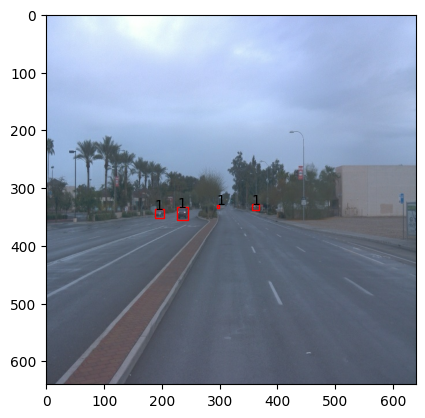

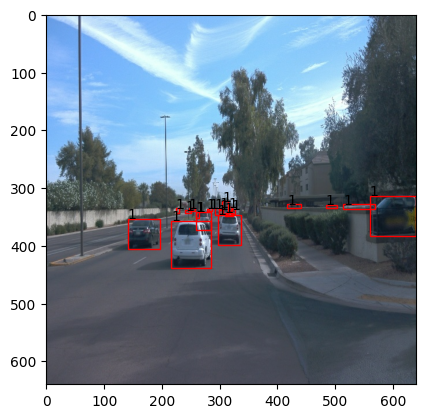

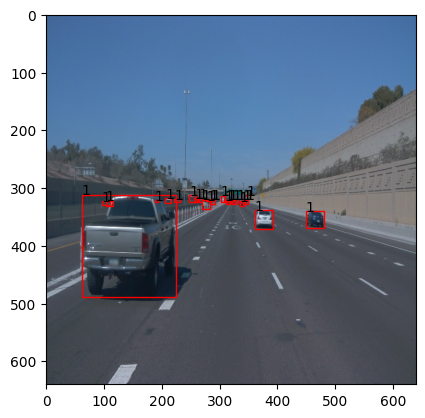

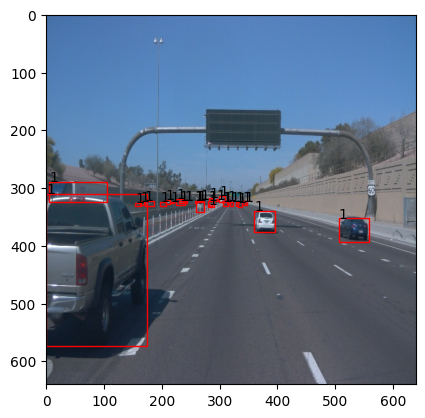

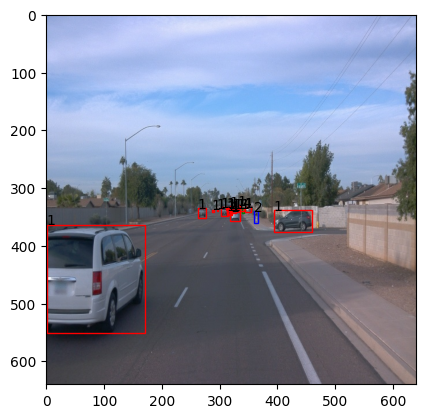

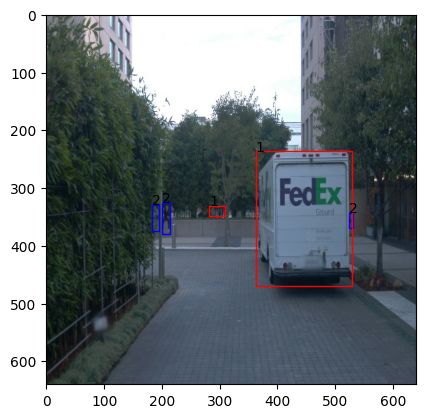

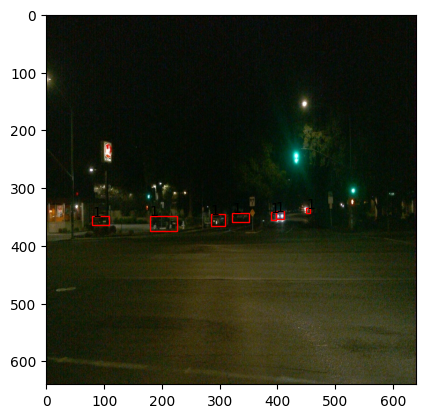

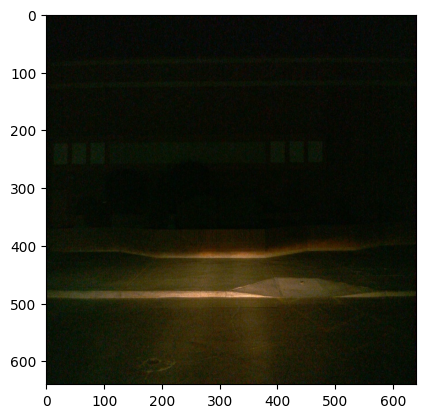

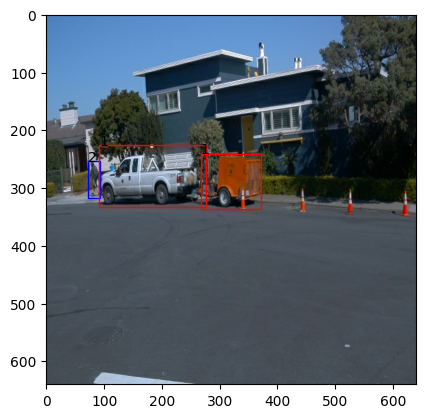

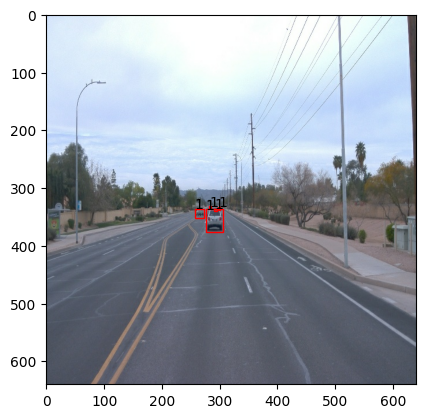

In [7]:
## STUDENT SOLUTION HERE
display_instances(10)

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [8]:

def area_under_bbox(image,bbox):
    # takes in image and a bounding box and returns its area
    y1,x1,y2,x2 = bbox
    y1 *= image.shape[0]
    y2 *= image.shape[0]
    x1 *= image.shape[1]
    x2 *= image.shape[1]
    return int((x2-x1)*(y2-y1))

In [22]:
def area_distributor(dataset):
    # takes in the dataset and returns a numpy array of the distribution of areas
    for sample_element in dataset.take(1):
        sample_image = sample_element['image'].numpy()
    all_areas = np.arange(0,409600)
    area_dist = np.zeros_like(all_areas)
    for element in dataset.take(10000):
        bboxes = element['groundtruth_boxes'].numpy()
        image = element['image'].numpy()
        for box in bboxes:
            area_dist[np.where(all_areas==area_under_bbox(image,box))] += 1
    return area_dist, all_areas

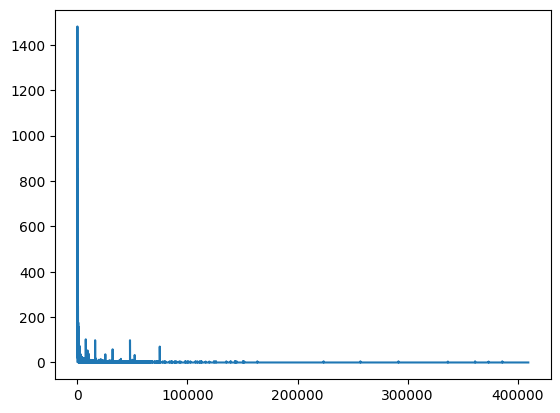

In [29]:
areas,all_areas = area_distributor(dataset)
plt.plot(areas)

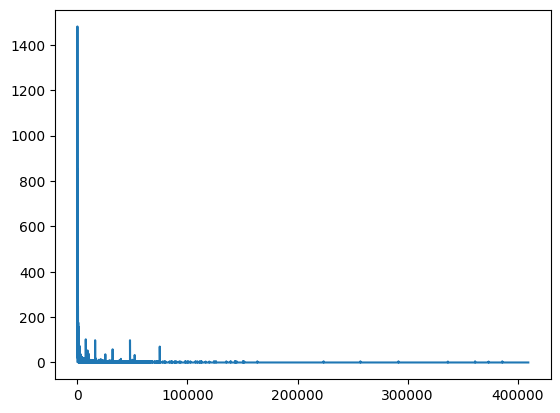

In [30]:
plt.plot(areas)

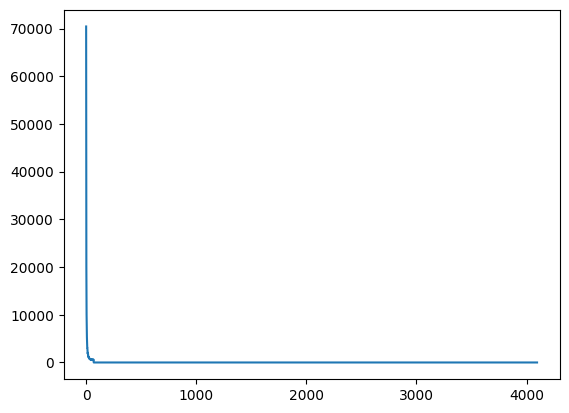

In [36]:
a = np.zeros(4096)
for i in range(a.shape[0]):
    a[i] = np.sum(areas[100*i:100*(i+1)])
plt.plot(a)

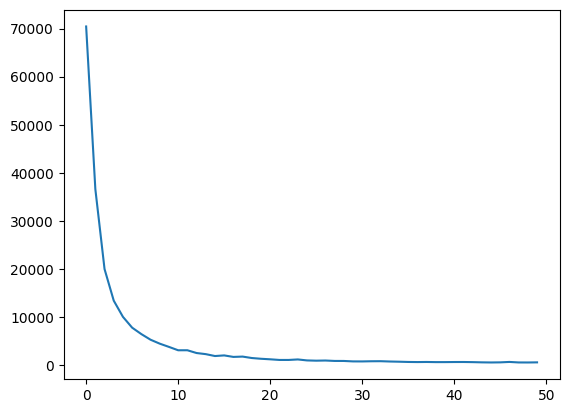

In [41]:
plt.plot(a[:50])

From the EDA performed, we can clearly see that the bulk of the areas of the bounding boxes lie in te 0-1000 range which is 0.0024 % of the image area or for a better visualization corresponds to a max bounding box of dimensions 32x32 approximately. The inference taken is that the objects in the image are, on an average smaller in size and we would be better off using two stage detectors